In [14]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import time
# from models.bioembeddings_dallago.lm_heads.prottrans_lms_factory import load_prottrans_lm_model

(16894, 33)
Index(['mut_id', 'pmd_id', 'nr', 'crossref', 'uniprot_id', 'ensembl_id',
       'taxid', 'protein', 'mut_PMD', 'mut_real', 'wt', 'mut', 'prot_pos',
       'function_summarized', 'functional_effect', 'function', 'seq', 'snp_id',
       'mrna_acc', 'mrna_ver', 'mrna_pos', 'allele', 'protein_acc',
       'protein_ver', 'verified', 'chrom', 'chrom_pos', 'variation',
       'variant_type', 'ref_allele', 'alt_allele', 'pmd_nr_id', 'pred'],
      dtype='object')


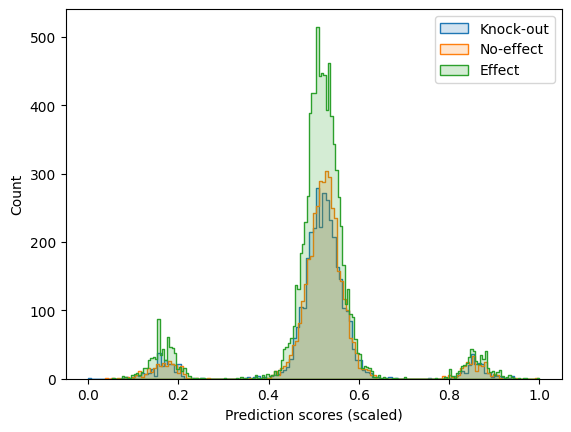

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_distribution(result_df, n_samples=None):
    df = result_df.copy(deep=True)
    plt.cla()

    effect = df[df["class"]=="Effect"]
    knock_out = df[df["class"]=="Knock-out"]
    no_effect = df[df["class"]=="No-effect"]

    if n_samples is not None:
        effect = effect.sample(n=n_samples)
        knock_out = knock_out.sample(n=n_samples)
        no_effect = no_effect.sample(n=n_samples)

    # print(effect.shape, knock_out.shape, no_effect.shape)
    bins = 100 # 20, 100, 500
    
    sns.histplot(knock_out["pred"], label=f"Knock-out", element="step", alpha=.2)
    sns.histplot(no_effect["pred"], label=f"No-effect", element="step", alpha=.2)
    sns.histplot(effect["pred"], label=f"Effect", element="step", alpha=.2)
    
    plt.legend()
    plt.xlabel("Prediction scores (scaled)")
    plt.ylabel("Count")
    plt.show()

result_df = pd.read_csv(home_dir+f"models/bioembeddings_dallago/outputs/prottrans_t5_bfd/pmd/preds_prottrans_t5_bfd.tsv", sep="\t")
result_df = result_df[result_df["crossref"].apply(lambda x: True if "HUMAN" in x else False)] # number of human entries: 16996
model_pred_col = "pred"
result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
print(result_df.shape)
print(result_df.columns)
result_df.rename(columns={"functional_effect": "class"}, inplace=True)
result_df["class"].value_counts()
plot_distribution(result_df, n_samples=None)

In [3]:
from bio_embeddings.embed import BeplerEmbedder
belper_embedder = BeplerEmbedder()
embedding = belper_embedder.embed("SEQVENCE")
embedding.shape

torch.Size([1, 8, 512])
torch.Size([1, 8, 100])


(8, 121)

In [2]:
import torch
import torch.nn.functional as F
# from bio_embeddings.embed import PLUSRNNEmbedder
from models.bioembeddings_dallago.lm_heads.plus_rnn_lm import PLUSRNNLM

plusrnn_lm = PLUSRNNLM()
print(plusrnn_lm._model)#.lm())
print(plusrnn_lm._model_cfg)
print(plusrnn_lm._tokenizer)
print(plusrnn_lm._tokenizer.encode("SEQVENCE".encode().upper()))
print(plusrnn_lm._tokenizer.convert_tokens_to_ids("H")) # 1-indexed

logits = plusrnn_lm.embed("SEQVENCE")
print(logits.shape)


/projects/ashehu/akabir4/venvs/hopper_bioembeddings_dallago_from_source/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PLUS_RNN(
  (embed): Embedding(22, 21, padding_idx=21)
  (rnn): LSTM(21, 512, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=100, bias=True)
  (decoder): Linear(in_features=1024, out_features=21, bias=True)
)
[16  7  6 20  7  3  5  7]
9
False
(8, 21)


In [3]:
plusrnn_lm._options

{'model_file': '/home/akabir4/.cache/bio_embeddings/plus_rnn/model_file'}

In [2]:
from bio_embeddings.embed import CPCProtEmbedder
cpc_embedder = CPCProtEmbedder()
print(cpc_embedder._model)
print(cpc_embedder.tokenizer.vocab)

/projects/ashehu/akabir4/venvs/hopper_bioembeddings_dallago_from_source/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPCProtModel(
  (enc): PatchedConvEncoder(
    (embedding): Embedding(30, 32)
    (conv1): Conv1d(32, 64, kernel_size=(4,), stride=(1,))
    (norm1): ChannelNorm()
    (conv2): Conv1d(64, 64, kernel_size=(6,), stride=(1,))
    (norm2): ChannelNorm()
    (conv3): Conv1d(64, 512, kernel_size=(3,), stride=(1,))
    (norm3): ChannelNorm()
  )
  (autoregressor): GRUAutoregressor(
    (gru): GRU(512, 512, batch_first=True)
  )
)


In [3]:
embedding = cpc_embedder.embed("SEQVENCE")
print(embedding.shape) # (1, 512)

CPCProtEmbedding(
  (cpc): CPCProtModel(
    (enc): PatchedConvEncoder(
      (embedding): Embedding(30, 32)
      (conv1): Conv1d(32, 64, kernel_size=(4,), stride=(1,))
      (norm1): ChannelNorm()
      (conv2): Conv1d(64, 64, kernel_size=(6,), stride=(1,))
      (norm2): ChannelNorm()
      (conv3): Conv1d(64, 512, kernel_size=(3,), stride=(1,))
      (norm3): ChannelNorm()
    )
    (autoregressor): GRUAutoregressor(
      (gru): GRU(512, 512, batch_first=True)
    )
  )
)
OrderedDict([('<pad>', 0), ('<mask>', 1), ('<cls>', 2), ('<sep>', 3), ('<unk>', 4), ('A', 5), ('B', 6), ('C', 7), ('D', 8), ('E', 9), ('F', 10), ('G', 11), ('H', 12), ('I', 13), ('K', 14), ('L', 15), ('M', 16), ('N', 17), ('O', 18), ('P', 19), ('Q', 20), ('R', 21), ('S', 22), ('T', 23), ('U', 24), ('V', 25), ('W', 26), ('X', 27), ('Y', 28), ('Z', 29)])


AttributeError: 'generator' object has no attribute 'shape'

In [2]:
from bio_embeddings.embed import SeqVecEmbedder # it took 13 mins to load 1st time
embedder = SeqVecEmbedder()


/projects/ashehu/akabir4/venvs/hopper_bioembeddings_dallago_from_source/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
print(embedder._model.elmo_bilm)
print(embedder._options_file) # from vim /home/akabir4/.cache/bio_embeddings/seqvec/options_file "n_tokens_vocab": 28
embedding = embedder.embed("SEQVENCE")
print(np.array(embedding).shape) # (3, 8, 1024)

_ElmoBiLm(
  (_token_embedder): _ElmoCharacterEncoder(
    (char_conv_0): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
    (char_conv_1): Conv1d(16, 32, kernel_size=(2,), stride=(1,))
    (char_conv_2): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
    (char_conv_3): Conv1d(16, 128, kernel_size=(4,), stride=(1,))
    (char_conv_4): Conv1d(16, 256, kernel_size=(5,), stride=(1,))
    (char_conv_5): Conv1d(16, 512, kernel_size=(6,), stride=(1,))
    (char_conv_6): Conv1d(16, 1024, kernel_size=(7,), stride=(1,))
    (_highways): Highway(
      (_layers): ModuleList(
        (0): Linear(in_features=2048, out_features=4096, bias=True)
        (1): Linear(in_features=2048, out_features=4096, bias=True)
      )
    )
    (_projection): Linear(in_features=2048, out_features=512, bias=True)
  )
  (_elmo_lstm): ElmoLstm(
    (forward_layer_0): LstmCellWithProjection(
      (input_linearity): Linear(in_features=512, out_features=16384, bias=False)
      (state_linearity): Linear(in_features=512, 

In [2]:
from bio_embeddings.embed import ProtTransBertBFDEmbedder
start = time.time()
e = ProtTransBertBFDEmbedder()
print(e._model_directory)
# print(e._model)
# print(e._tokenizer)

end = time.time()
print(f"Time taken to load model in CPU: {end-start} s")

/projects/ashehu/akabir4/venvs/hopper_bioembeddings_dallago_from_source/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [4]:
print(e._tokenizer.convert_tokens_to_ids("A"))

6


In [3]:
embedding = e.embed("SEQVENCE")
print(np.array(embedding).shape) # 8, 1024; 0-indexed

(8, 30)


In [2]:
from bio_embeddings.embed import ProtTransAlbertBFDEmbedder
start = time.time()
albert_embedder = ProtTransAlbertBFDEmbedder()
print(albert_embedder._model_directory)
print(albert_embedder._model)
print(albert_embedder._tokenizer)

end = time.time()
print(f"Time taken to load model in CPU: {end-start} s")

Alhumdulillah


Some weights of the model checkpoint at /home/akabir4/.cache/bio_embeddings/prottrans_albert_bfd/model_directory were not used when initializing AlbertForMaskedLM: ['sop_classifier.classifier.bias', 'sop_classifier.classifier.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/home/akabir4/.cache/bio_embeddings/prottrans_albert_bfd/model_directory
AlbertForMaskedLM(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(34, 128, padding_idx=0)
      (position_embeddings): Embedding(40000, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=4096, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((4096,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=4096, out_features=4096, bias=True)
                (key): Linear(in_features=4096, out_features=4096, bias=True)
  

In [4]:
embedding = albert_embedder.embed("SEQVENCE")
print(np.array(embedding).shape) # 8, 1024; 0-indexed

torch.Size([1, 10, 34])
(8, 34)


In [3]:
from bio_embeddings.embed import ProtTransXLNetUniRef100Embedder
start = time.time()
xlnet_embedder = ProtTransXLNetUniRef100Embedder()
print(xlnet_embedder._model)
print(xlnet_embedder._tokenizer)

end = time.time()
print(f"Time taken to load model in CPU: {end-start} s")

Alhumdulillah
XLNetLMHeadModel(
  (transformer): XLNetModel(
    (word_embedding): Embedding(37, 1024)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=1024, out_features=4096, bias=True)
          (layer_2): Linear(in_features=4096, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): ReLU()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
     

/projects/ashehu/akabir4/venvs/hopper_bioembeddings_dallago_from_source/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1706: FutureWarning: Calling XLNetTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


In [3]:
embedding = xlnet_embedder.embed("SEQVENCE")
print(np.array(embedding).shape) # 8, 1024; 0-indexed

(8, 37)


In [2]:
from bio_embeddings.embed import ProtTransT5BFDEmbedder
start = time.time()
t5bdf_embedder = ProtTransT5BFDEmbedder()
print(t5bdf_embedder._model)
print(t5bdf_embedder._tokenizer)

end = time.time()
print(f"Time taken to load model in CPU: {end-start} s")

/projects/ashehu/akabir4/venvs/hopper_bioembeddings_dallago_from_source/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Alhumdulillah
True
T5ForConditionalGeneration(
  (shared): Embedding(128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=False)

In [3]:
embedding = t5bdf_embedder.embed("SEQVENCE")
print(np.array(embedding).shape) # 

torch.Size([1, 9, 128])
(8, 128)


In [4]:
from bio_embeddings.embed import ProtTransT5UniRef50Embedder
start = time.time()
t5uniref_embedder = ProtTransT5UniRef50Embedder()
print(t5uniref_embedder._model)
print(t5uniref_embedder._tokenizer)

end = time.time()
print(f"Time taken to load model in CPU: {end-start} s")

Alhumdulillah
True
T5ForConditionalGeneration(
  (shared): Embedding(128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=False)

In [5]:
embedding = t5uniref_embedder.embed("SEQVENCE")
print(np.array(embedding).shape) # 

torch.Size([1, 9, 128])
(8, 128)


In [6]:
from bio_embeddings.embed import ProtTransT5XLU50Embedder
start = time.time()
t5xl_embedder = ProtTransT5UniRef50Embedder()
print(t5xl_embedder._model)
print(t5xl_embedder._tokenizer)

end = time.time()
print(f"Time taken to load model in CPU: {end-start} s")

Alhumdulillah
True
T5ForConditionalGeneration(
  (shared): Embedding(128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=False)

In [7]:
embedding = t5xl_embedder.embed("SEQVENCE")
print(np.array(embedding).shape) # 

torch.Size([1, 9, 128])
(8, 128)
